# Sitemap Assay

The start of a simple notebook that could hosted for peeopl to test out their sitemaps (and robots.txt) files with.

References:
* [AdvTools](https://advertools.readthedocs.io/en/master/advertools.sitemaps.html)
* [Sitemap viz](https://www.ayima.com/us/insights/analytics-and-cro/how-to-visualize-an-xml-sitemap-using-python.html)



In [1]:
import advertools as adv
import json
import requests
from pyld import jsonld
from bs4 import BeautifulSoup
import urllib.request
import logging
import traceback
import kglab

/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


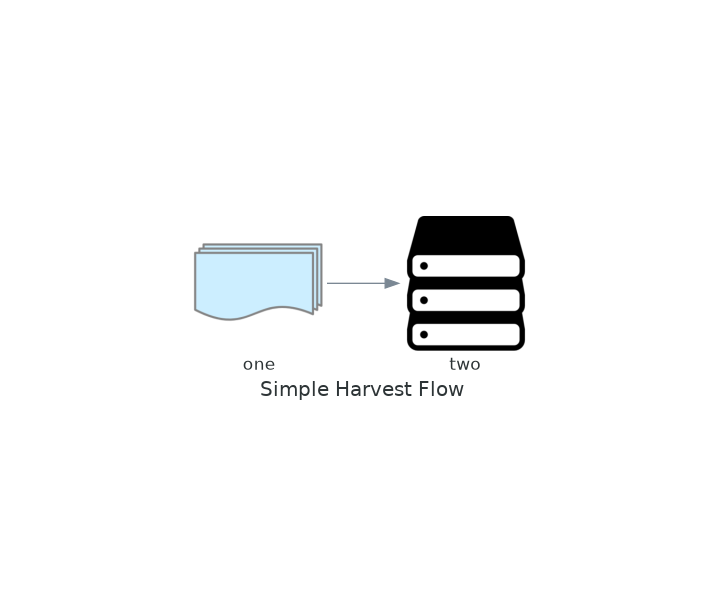

In [2]:
from diagrams import Cluster, Diagram
from diagrams.aws.compute import ECS
from diagrams.aws.database import ElastiCache, RDS
from diagrams.aws.network import ELB
from diagrams.aws.network import Route53
from diagrams.generic.blank import Blank
from diagrams.generic.place import Datacenter
from diagrams.generic.storage import Storage
from diagrams.programming.flowchart import MultipleDocuments



with Diagram("Simple Harvest Flow", show=False) as imgdia:
    
    b1 = MultipleDocuments("one")
    b2 = Storage("two")
    
    b1 >> b2

    
imgdia



In [2]:
%%time 

smurl = 'https://obis.org/sitemap/sitemap_datasets.xml'
# smurl = 'https://infohub.eurocean.net/sitemap/vessels'

iow_sitemap = adv.sitemap_to_df(smurl) # load sitemap to dataframe via advertools

2022-05-10 09:40:58,427 | INFO | sitemaps.py:419 | sitemap_to_df | Getting https://obis.org/sitemap/sitemap_datasets.xml


CPU times: user 98.8 ms, sys: 19.4 ms, total: 118 ms
Wall time: 1.19 s


/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/advertools/sitemaps.py:421: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sitemap_df = sitemap_df.append(elem_df, ignore_index=True)


In [3]:
iow_sitemap.info()
iow_sitemap.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473 entries, 0 to 4472
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   loc              4473 non-null   object             
 1   changefreq       4473 non-null   object             
 2   priority         4473 non-null   float64            
 3   sitemap          4473 non-null   object             
 4   etag             4473 non-null   object             
 5   sitemap_size_mb  4473 non-null   float64            
 6   download_date    4473 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), object(4)
memory usage: 244.7+ KB


,loc,changefreq,priority,sitemap,etag,sitemap_size_mb,download_date
0,https://obis.org/dataset/ec6bfce3-b62c-4a2b-b0...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a71bf-/bQ5LCsirhJmeGsIxcn8X1eXo2A,0.65277,2022-05-10 14:40:58.479974+00:00
1,https://obis.org/dataset/2dffebfc-8132-445e-a1...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a71bf-/bQ5LCsirhJmeGsIxcn8X1eXo2A,0.65277,2022-05-10 14:40:58.479974+00:00
2,https://obis.org/dataset/7fba9a43-a900-46a5-8a...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a71bf-/bQ5LCsirhJmeGsIxcn8X1eXo2A,0.65277,2022-05-10 14:40:58.479974+00:00
3,https://obis.org/dataset/739c0486-3adf-4e88-9f...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a71bf-/bQ5LCsirhJmeGsIxcn8X1eXo2A,0.65277,2022-05-10 14:40:58.479974+00:00
4,https://obis.org/dataset/73f31d9e-9c11-402b-9e...,weekly,1.0,https://obis.org/sitemap/sitemap_datasets.xml,W/a71bf-/bQ5LCsirhJmeGsIxcn8X1eXo2A,0.65277,2022-05-10 14:40:58.479974+00:00


## Unique Sitemaps URLs and resource URLs in IoW

We can quickly grabe the unique URLs from the sitemap column and see how many unique sitemap.xml files we are working with

In [4]:
usm = iow_sitemap.sitemap.unique()
uloc = iow_sitemap["loc"].unique()
print("{} unique sitemap XML file(s) pointing to {} unique resource(s).".format(len(usm), len(uloc)))

1 unique sitemap XML file(s) pointing to 4473 unique resource(s).


## Analyzing the URLs

We can also dive into the URL structure for the resources a bit. 

In [5]:
# Break down all the URL into theor path parts
urldf = adv.url_to_df(list(iow_sitemap['loc']))
urldf.head()

,url,scheme,netloc,path,query,fragment,dir_1,dir_2
0,https://obis.org/dataset/ec6bfce3-b62c-4a2b-b0...,https,obis.org,/dataset/ec6bfce3-b62c-4a2b-b071-0d5856def57f,,,dataset,ec6bfce3-b62c-4a2b-b071-0d5856def57f
1,https://obis.org/dataset/2dffebfc-8132-445e-a1...,https,obis.org,/dataset/2dffebfc-8132-445e-a127-3a360208a7b3,,,dataset,2dffebfc-8132-445e-a127-3a360208a7b3
2,https://obis.org/dataset/7fba9a43-a900-46a5-8a...,https,obis.org,/dataset/7fba9a43-a900-46a5-8a4c-861399705482,,,dataset,7fba9a43-a900-46a5-8a4c-861399705482
3,https://obis.org/dataset/739c0486-3adf-4e88-9f...,https,obis.org,/dataset/739c0486-3adf-4e88-9f8d-f0b48ea9b5ad,,,dataset,739c0486-3adf-4e88-9f8d-f0b48ea9b5ad
4,https://obis.org/dataset/73f31d9e-9c11-402b-9e...,https,obis.org,/dataset/73f31d9e-9c11-402b-9e3d-8ed61f2fcc8c,,,dataset,73f31d9e-9c11-402b-9e3d-8ed61f2fcc8c


In [6]:
#set the column sof interest
coi = "query"

In [7]:
# We can not aggregate at various levels...   
e4 = urldf[coi].value_counts()
e4.rename_axis("sources")

e4df = e4.to_frame()
e4df.head(len(e4)) 

,query
,4473


## Plot sitemap diversity

This following section is only of value in cases where is a diversity of path names above the final resource entry in a sitemap.
Otherwise these sections provide no insight.

Note that the _Plot sitemap diversity_ section my not be of value for many groups.  It was used in cases where the URL path has
 more varied structure.  In some cases the structure is the same till the end path element.  In those cases the graphs will be
 busy (slow) and not very useful.

In [8]:
# If we have lots of values above, then we can sum lower end ones into an "others" category.
# This is not needed if the breakdown is small or 1 above the final resource entry in a sitemap.
# With a little trial and error we can see the cutoff for a chart 
breakat = 1
ts = e4df.tail(breakat)[coi].sum()
e4topdf = e4df# [e4df[coi]]  # work in using breakat to get this
e4topdf.reset_index(inplace = True, drop = False)
e4topdf.rename(columns={'index': 'source', coi:'count'},  inplace = True)

t = e4topdf.append({'source':'other', 'count':ts}, ignore_index=True) 
t.head(10)

/tmp/ipykernel_918243/569473460.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t = e4topdf.append({'source':'other', 'count':ts}, ignore_index=True)


,source,count
0,,4473
1,other,4473


<AxesSubplot:ylabel='count'>

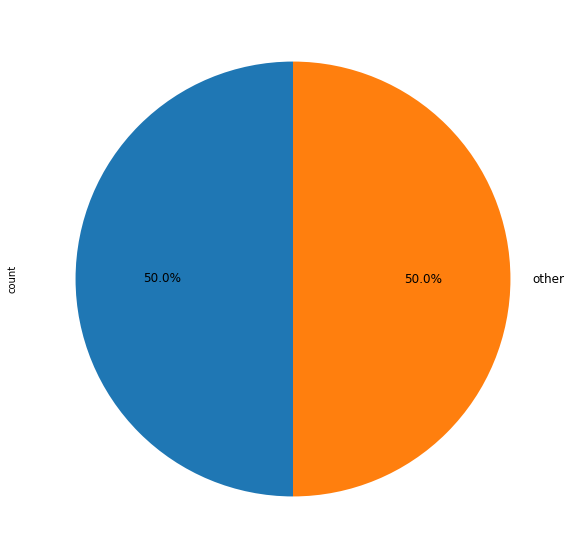

In [9]:
import matplotlib.pyplot as plt
from pandas.plotting import table

plt.figure(figsize=(30,10))

# plot chart
ax1 = plt.subplot(121, aspect='equal')
t.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=t['source'], legend = False, fontsize=12)

# # plot table
# ax2 = plt.subplot(122,  aspect='equal')
# plt.axis('off')
# tbl = table(ax2, t, loc='center')
# tbl.auto_set_font_size(False)
# tbl.set_fontsize(12)
# plt.show()

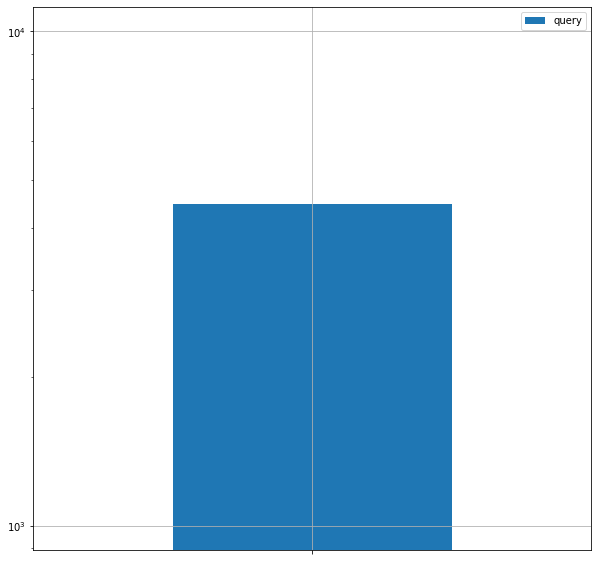

In [10]:
e4sort = e4.sort_values(ascending=True)
plot = e4sort.plot.bar(y='dir_4',legend=True, grid=True, logy = True, figsize=(10, 10))

## Sample and test sitemap entries

In [11]:
# sample the previously generated url data frame
sample_size = 5
sample_df = urldf.groupby("dir_1").sample(n=sample_size, random_state=1, replace=True)


In [12]:
sample_df.head()

,url,scheme,netloc,path,query,fragment,dir_1,dir_2
235,https://obis.org/dataset/d7bdf4c6-7418-4c4a-98...,https,obis.org,/dataset/d7bdf4c6-7418-4c4a-9845-311d5b9475a3,,,dataset,d7bdf4c6-7418-4c4a-9845-311d5b9475a3
3980,https://obis.org/dataset/27cd0137-820a-485e-bf...,https,obis.org,/dataset/27cd0137-820a-485e-bf8a-90117801313c,,,dataset,27cd0137-820a-485e-bf8a-90117801313c
905,https://obis.org/dataset/80f2d19f-d8a3-4664-99...,https,obis.org,/dataset/80f2d19f-d8a3-4664-999b-5fde219ddde8,,,dataset,80f2d19f-d8a3-4664-999b-5fde219ddde8
2763,https://obis.org/dataset/a4bb1978-5aa4-4fd2-b8...,https,obis.org,/dataset/a4bb1978-5aa4-4fd2-b8f3-ffc19b6467dc,,,dataset,a4bb1978-5aa4-4fd2-b8f3-ffc19b6467dc
2895,https://obis.org/dataset/14242931-d643-4f29-a5...,https,obis.org,/dataset/14242931-d643-4f29-a505-4d8eab59751b,,,dataset,14242931-d643-4f29-a505-4d8eab59751b


### See the URLs resolve

In [13]:
import urllib.request
import requests

ul = sample_df["url"]

for item in ul:
    headers, code, dtype = None, None, None
    
    try:
        x = requests.get(item)
        code = x.status_code
        with urllib.request.urlopen(item) as response:
            info = response.info()
            dtype = info.get_content_type()    # -> text/html

        # headers = x.headers()
    except:
        code = "exception"
        dtype = "exception"
        headers = "exception"
    
    print("URL: {} \ncode {} : {} \nerrors : {}\n --".format(item, code, dtype, headers))

URL: https://obis.org/dataset/d7bdf4c6-7418-4c4a-9845-311d5b9475a3 
code 200 : text/html 
errors : None
 --
URL: https://obis.org/dataset/27cd0137-820a-485e-bf8a-90117801313c 
code 200 : text/html 
errors : None
 --
URL: https://obis.org/dataset/80f2d19f-d8a3-4664-999b-5fde219ddde8 
code 200 : text/html 
errors : None
 --
URL: https://obis.org/dataset/a4bb1978-5aa4-4fd2-b8f3-ffc19b6467dc 
code 200 : text/html 
errors : None
 --
URL: https://obis.org/dataset/14242931-d643-4f29-a505-4d8eab59751b 
code 200 : text/html 
errors : None
 --


### See if they have JSON-LD (static check only, no dynamically loaded JSON-LD yet)

In [23]:
ul = sample_df["url"]


for item in ul:
    html = urllib.request.urlopen(item).read()
    soup = BeautifulSoup(html, "html.parser")
    p = soup.find('script', {'type':'application/ld+json'})
    try:
        print(len(p.contents[0]))
        # print(p.contents[0])
        print("-----------------")
    except Exception as e:
        logging.error(traceback.format_exc())

4375
-----------------
6040
-----------------
2462
-----------------
2831
-----------------
2108
-----------------


### Check JSON-LD structure (static check only, no dynamically loaded JSON-LD yet)

In [16]:
ul = sample_df["url"]

myframe =  {
    "@context":{"@vocab": "https://schema.org/"},
    "@type": "Dataset",
}

context =  { "@vocab": "https://schema.org/" }

for item in ul:
    html = urllib.request.urlopen(item).read()
    soup = BeautifulSoup(html, "html.parser")
    p = soup.find('script', {'type':'application/ld+json'})
    try:
        jld = json.loads(p.contents[0])
        compacted = jsonld.compact(jld, context)
        print(len(json.dumps(compacted, indent=2)))
    except Exception as e:
        logging.error(traceback.format_exc())

3879
5846
2358
2617
1892


## COMING SOON

Looad a sample set of triples into RDF lib and run a sample SPARQL query on them.

### Note
This is the same loop as above but now we will load into a KG graph

In [24]:
ul = sample_df["url"]

# Test loading into a graph
namespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
}

kg = kglab.KnowledgeGraph(
    name = "Schema.org shacl eval datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
)



for item in ul:
    html = urllib.request.urlopen(item).read()
    soup = BeautifulSoup(html, "html.parser")
    p = soup.find('script', {'type':'application/ld+json'})
    try:
        print(len(p.contents[0]))
        kg.load_rdf_text(data=p.contents[0], format="json-ld")
        # print(p.contents[0])
        print("-----------------")
    except Exception as e:
        logging.error(traceback.format_exc())

4375
-----------------
6040
-----------------
2462
-----------------
2831
-----------------
2108
-----------------


In [25]:
sparql = """
PREFIX schema: <https://schema.org/>
SELECT ?s
  WHERE {
    ?s a schema:Organization
  }
"""

df = kg.query_as_df(sparql).to_pandas()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s       3 non-null      object
dtypes: object(1)
memory usage: 152.0+ bytes


In [26]:
df.head()

,s
0,<https://oceanexpert.org/institution/6223>
1,<https://oceanexpert.org/institution/19393>
2,<https://oceanexpert.org/institution/12745>
